# Complex numbers

This section covers the fundamentals of complex numbers, and should help give a sense of how and why they're useful for modeling periodic phenomena such as audio signals.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.path as path
import matplotlib.patches as patches
from matplotlib.transforms import Bbox
import warnings
warnings.simplefilter('ignore')

from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('bauhaus')

np.random.seed(20200101)

colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

def figaspect(arg):
    # min/max sizes to respect when autoscaling.  If John likes the idea, they
    # could become rc parameters, for now they're hardwired.
    figsize_min = np.array((4.0, 2.0))  # min length for width/height
    figsize_max = np.array((16.0, 16.0))  # max length for width/height

    # Extract the aspect ratio of the array
    isarray = hasattr(arg, 'shape') and not np.isscalar(arg)
    if isarray:
        nr, nc = arg.shape[:2]
        arr_ratio = nr / nc
    else:
        arr_ratio = arg

    # Height of user figure defaults
    fig_width = matplotlib.rcParams['figure.figsize'][0]

    # New size for the figure, keeping the aspect ratio of the caller
    newsize = np.array((fig_width, fig_width *arr_ratio))
    #newsize = np.array((fig_height / arr_ratio, fig_height))

    # Sanity checks, don't drop either dimension below figsize_min
    newsize /= min(1.0, *(newsize / figsize_min))

    # Avoid humongous windows as well
    newsize /= max(1.0, *(newsize / figsize_max))

    # Finally, if we have a really funky aspect ratio, break it but respect
    # the min/max dimensions (we don't want figures 10 feet tall!)
    newsize = np.clip(newsize, figsize_min, figsize_max)
    return newsize

## Why use complex numbers?

Complex numbers were originally developed to solve polynomial equations (e.g., find $x$ such that $x^2 + x + 1 = 0$), and it's true that many of the things we do in signal processing involve exactly these kinds of equations.
However, this isn't a terribly satisfying motivation for using complex numbers to study signal processing, and this is the point at which many students start to get very confused about why we need all of this math.

There is, however, a much deeper reason why complex numbers arise in signal processing, and it has to do with the link between arithmetic and geometry.

Think about what happens when you multiply one real number $x$ by another $y$.
If $y > 1$, then $x\cdot y$ becomes bigger than $x$, which you can think of as *stretching* the number line.
If $y < 1$, then $x \cdot y$ becomes smaller, which embodies the opposite effect, *compressing* the number line.
And if $y < 0$, then the sign of $x\cdot y$ flips from $x$'s (positive becomes negative, and vice versa), which you can think of as *mirroring* the number line horizontally.
Stretching, compressing, and reflecting are all familiar **geometric** operations that happen to correspond to the arithmetic of real numbers.

In [2]:
%%capture
# Plot number line operations here
#  magnitude oscillating 1 + 0.5 * cos
fig, ax = plt.subplots(figsize=figaspect(1./4))

duration = 20
frame_rate = 25
#frame_rate = 4
n_frames = duration * frame_rate

x = 1.5
y = 0.25 + 2 * np.sin(2 * np.pi * 3 * np.linspace(0, 1, num=n_frames, endpoint=False))

xy = x * y

xp = ax.scatter(x, 0, color=colors[0], label=r'$x$', s=60)
xt = ax.text(x + .1,  .15, r'$x$', color=colors[0], size=25)

yp = ax.scatter(y[0], 0, color=colors[1], label=r'$y$', s=60)
yt = ax.text(y[0] + .1,  .15, r'$y$', color=colors[1], size=25)

xyp = ax.scatter(xy[0], 0, color=colors[4], label=r'$x\cdot y$')
xyt = ax.text(xy[0] + .1, -0.05, r'$x \cdot y$', color=colors[4], size=25, va='top')

ax.axhline(0, color=colors[3], zorder=-1, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-1, linewidth=2)
#ax.axis('off')
ax.set_yticks([])
ax.set_xlim(-5, 5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel(r'Real numbers $\leftrightarrow$')

def init():
    return yp, xyp, yt, xyt

def animate(frame):
    
    yp.set_offsets(np.c_[y[frame], 0])
    xyp.set_offsets(np.c_[xy[frame], 0])

    yt.set_x(y[frame] + 0.1)
    xyt.set_x(xy[frame] + 0.1)
    return yp, xyp, yt, xyt


animation = FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(n_frames),
                               interval=1000/frame_rate, blit=True);

In [3]:
animation

But what if the numbers are complex instead of real?  It turns out that you still get the same basic types of operations (stretching, compressing, and reflecting), but now in *two* dimensions instead of 1.
But there's an additional **twist** (literally!): complex multiplication also **rotates** points in the plane.
Rotation is a one of the simplest models of periodicity, just ask any clock-maker!

How exactly does this all work?  Keep reading...

## Definition

Recall that there is no **real** number $x$ such that $x^2 = -1$.
However, if we *imagine* a "number" $\mathrm{j}$ (which need not be **real**) such that $\mathrm{j}^2 = -1$, it turns out that this leads to a whole new type of numbers, which we call **complex**.

As a general convention, to avoid confusion, it is common to denote real numbers by $x$ and $y$ and complex numbers by $z$ and $w$.

Formally, a complex number $z$ consists of a $\color{#EC2830}{\text{real part}}$ and an $\color{#6E3B87}{\text{imaginary part}}$.
We can equivalently think of the imaginary part as being a real number multiplied by $\mathrm{j}$, so that the complex number can be expressed succinctly as

$$
z = \color{#EC2830}{a} + \mathrm{j}\color{#6E3B87}b.
$$

You can think of $\color{#EC2830}a$ as "how much real is in $z$", and $\color{#6E3B87}b$ as "how much imaginary is in $z$".
If $\color{#EC2830}a=0$, then $z=\mathrm{j}\color{#6E3B87}b$ is called **purely imaginary**.
Likewise, if $\color{#6E3B87}b=0$, then $z=\color{#EC2830}a$ is called **purely real**.

In Python, we can represent complex numbers using a very similar notation:

```{margin}
*Note*: it does not work to say 

`z = 1 + j` 

because Python will interpret `j` as a variable if there isn't a number in front of it.

Instead, say `z = 1 + 1j`.
```

In [4]:
z = 1 + 2j
print(z)

(1+2j)


We can then extract their real and imaginary parts by accessing `z.real` and `z.imag`:

In [5]:
print('Real part:       {}'.format(z.real))
print('Imaginary part: {}'.format(z.imag))

Real part:       1.0
Imaginary part: 2.0


This representation of $z$ is known as the **rectangular form**, as you can interpret the real and imaginary parts as length and width of a rectangle.
Interpreting complex numbers in this way leads to a natural way to reason about them as points in a two-dimensional plane, where the horizontal position measures the real part, and the vertical axis measures the imaginary part.
The figure below demonstrates this idea, and shows the position of a few selected complex numbers $z$.

```{margin}
When we draw visualize numbers in the **complex plane**, it is helpful to include a few extra pieces of information.

The horizontal axis is the *real number line*: numbers landing exactly on this line are purely real.
Similarly, the vertical axis is the *imaginary number line*.

Finally, for reasons that will become clear below, it is also helpful to include a circle of radius 1.
Numbers that land on the boundary of this circle all have equal distance from 0, and these numbers play a special role in signal processing.
```

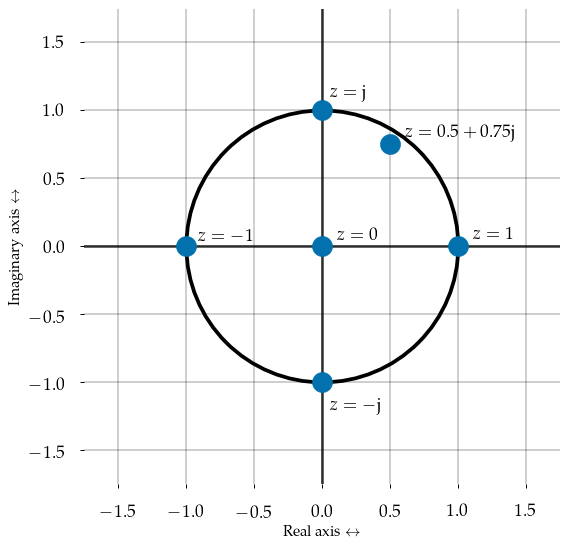

In [6]:
# Plot a circle, inscribed right triangle, angle, and sine and cosine markers

z = np.asarray([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1], [0.5, 0.75]])

fig, ax = plt.subplots(figsize=figaspect(0.75))

ax.scatter(z[:,0], z[:, 1])

circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-1)
ax.add_artist(circ)
ax.axhline(0, color=colors[3], zorder=-1, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-1, linewidth=2)

ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');

ax.text(.1, 0.05, r'$z=0$');
ax.text(1.1, 0.05, r'$z=1$');
ax.text(0.05, 1.1, r'$z=\mathrm{j}$');
ax.text(0.05, -1.2, r'$z=-\mathrm{j}$');
ax.text(-0.92, 0.05, r'$z=-1$');
ax.text(.6, 0.81, r'$z=0.5 + 0.75\mathrm{j}$');
ax.set_aspect('equal')
ax.set_xlim([-1.75, 1.75])
ax.set_ylim([-1.75, 1.75]);

It is tempting to think of a complex number as having two independent pieces ($a$ and $b$), and it is sometimes helpful to do so.
However, one must always keep in mind that this representation is primarily for convenience, and a complex number should always be treated holistically.
A complex number has more structure than an arbitary pair of points $(x, y)$ because of the special interpretation of the imaginary unit $\mathrm{j}$.
We'll see why exactly this is the case soon.

## Basic operations

### Addition and subtraction

If we have two complex numbers $\color{#EC2830}a + \mathrm{j}\color{#6E3B87}b$ and $\color{#EC2830}c + \mathrm{j}\color{#6E3B87}d$, their sum is defined by independently summing the real parts ($\color{#EC2830}{a+c}$) and the imaginary parts ($\color{#6E3B87}{b+d}$):

$$
(\color{#EC2830}a + \mathrm{j}\color{#6E3B87}b) + (\color{#EC2830}c + \mathrm{j}\color{#6E3B87}d) = (\color{#EC2830}{a+c}) + \mathrm{j}(\color{#6E3B87}{b+d}).
$$

Subtraction works similarly:

$$
(\color{#EC2830}a + \mathrm{j}\color{#6E3B87}b) - (\color{#EC2830}c + \mathrm{j}\color{#6E3B87}d) = (\color{#EC2830}{a-c}) + \mathrm{j}(\color{#6E3B87}{b-d}).
$$

In the complex plane, addition and subtraction can be thought of as displacement.
If you imagine drawing an arrows from the origin $0$ to the positions of $z$ and $w$, then you can find the position of $z+w$ by picking up one of the arrows and moving its tail to coincide with the head of the other arrow.
Subtraction works the same way, except that you would turn the arrow around $180^\circ$.

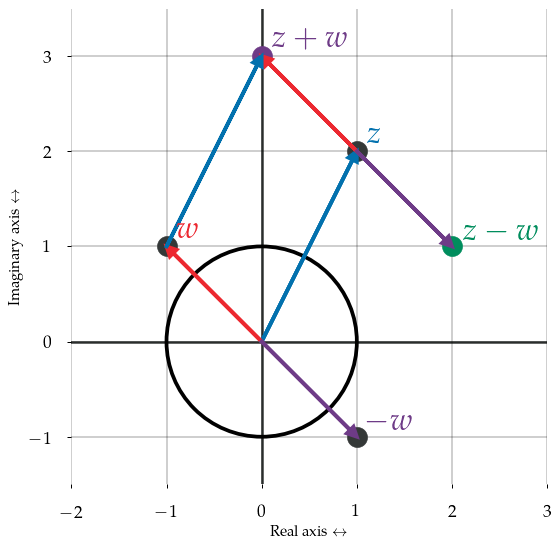

In [7]:
fig, ax = plt.subplots(figsize=figaspect(0.75))
ax.scatter(1, 2, color=colors[3], label=r'$z$')
ax.text(1.1, 2.1, r'$z$', color=colors[0], size=25)
ax.arrow(0, 0, 1, 2, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[0], ec=colors[0], length_includes_head=True)

ax.scatter(-1, 1, color=colors[3], label=r'$w$')
ax.text(-.9, 1.1, r'$w$', color=colors[1], size=25)
ax.arrow(0, 0, -1, 1, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[1], ec=colors[1], length_includes_head=True)

ax.scatter(1, -1, color=colors[3], label=r'$-w$')
ax.text(1.1, -0.9, r'$-w$', color=colors[4], size=25)
ax.arrow(0, 0, 1, -1, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[4], ec=colors[4], length_includes_head=True)

ax.scatter(0, 3, color=colors[4], label=r'$z+w$')
ax.text(0.1, 3.1, r'$z+w$', color=colors[4], size=25)
ax.plot([-1, 0], [1, 3], color=colors[0], linewidth=2, linestyle=':', zorder=-1)
ax.arrow(1, 2, -1, 1, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[1], ec=colors[1], length_includes_head=True)
ax.arrow(-1, 1, 1, 2, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[0], ec=colors[0], length_includes_head=True)

ax.scatter(2, 1, color=colors[5], label=r'$z-w$')
ax.text(2.1, 1.1, r'$z-w$', color=colors[5], size=25)

ax.arrow(1, 2, 1, -1, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[4], ec=colors[4], length_includes_head=True)
circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-1)
ax.add_artist(circ)
ax.axhline(0, color=colors[3], zorder=-1, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-1, linewidth=2)

ax.set_xlim(-2, 3)
ax.set_ylim(-1.5, 3.5)
ax.set_aspect('equal')
ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');

## Conjugation

Complex numbers have a new operation, which doesn't exist for other systems like reals and integers, called *conjugation*.
The complex conjugate of a number $z = \color{#EC2830}a + \mathrm{j}\color{#6E3B87}b$, denoted as $\overline{z}$, is computed by negating *only the imaginary part*, and is denoted by an over-line:

$$
\overline{z} = \overline{\color{#EC2830}a + \mathrm{j}\color{#6E3B87}b} = \color{#EC2830}a - \mathrm{j}\color{#6E3B87}b.
$$

Visually, this operation reflects a point across the horizontal (real) axis in the complex plane, as seen below.

Conjugating a number twice reverts back to the original number (just like negating a number twice).

If a number is purely real (has $b=0$), it lies exactly on the horizontal axis, and it is its own conjugate.

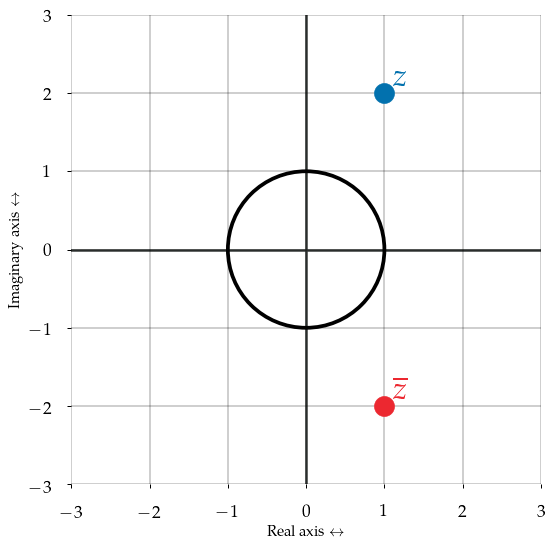

In [8]:
fig, ax = plt.subplots(figsize=figaspect(0.75))

ax.scatter(1, 2, color=colors[0], label=r'$z$')
ax.text(1.1, 2.1, r'$z$', color=colors[0], size=25)


ax.scatter(1, -2, color=colors[1], label=r'$\overline{z}$')
ax.text(1.1, -1.9, r'$\overline{z}$', color=colors[1], size=25)

ax.axhline(0, color=colors[3], zorder=-1, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-1, linewidth=2)
circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-1)
ax.add_artist(circ)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');

## Multiplication (take 1)

There are two ways to think about multiplication of complex numbers, depending on whether we use *rectangular* or *polar* form, which we'll see below.
Both are equally valid, and produce the same results, but sometimes one may be more convenient than the other.
Let's start with the rectangular form.

If we have two complex numbers $z = \color{#EC2830}a + \mathrm{j}\color{#6E3B87}b$ and $w = \color{#EC2830}c + \mathrm{j}\color{#6E3B87}d$, we can compute their product by using the rules of algebra and remembering that $\mathrm{j}\cdot\mathrm{j} = -1$:

$$
\begin{align*}
z \cdot w &= (\color{#EC2830}a + \mathrm{j}\color{#6E3B87}b) \cdot (\color{#EC2830}c + \mathrm{j}\color{#6E3B87}d) & \text{Use definitions of } z, w\\
&= \color{#EC2830}a \cdot \color{#EC2830}c + \color{#EC2830}a\cdot \mathrm{j}\color{#6E3B87}d + \mathrm{j}\color{#6E3B87}b \cdot \color{#EC2830}c + \mathrm{j}\color{#6E3B87}b \cdot \mathrm{j}\color{#6E3B87}d  & \text{FOIL multiply}\\
&= \color{#EC2830}a \cdot \color{#EC2830}c +  \mathrm{j}\left(\color{#EC2830}a\cdot\color{#6E3B87}d + \color{#6E3B87}b \cdot \color{#EC2830}c\right) + \mathrm{j}^2\left(\color{#6E3B87}b \cdot \color{#6E3B87}d\right)  & \text{Pull out imaginary units } \mathrm{j}\\
&= \color{#EC2830}a \cdot \color{#EC2830}c + \mathrm{j}\left(\color{#EC2830}a\cdot\color{#6E3B87}d + \color{#6E3B87}b \cdot \color{#EC2830}c\right) - \color{#EC2830}b \cdot \color{#EC2830}d  & \mathrm{j}^2 = -1\\
&= \left(\color{#EC2830}a \cdot \color{#EC2830}c - \color{#EC2830}b \cdot \color{#EC2830}d\right) + \mathrm{j}\left( \color{#6E3B87}a \cdot \color{#6E3B87}d + \color{#6E3B87}b \cdot \color{#6E3B87}c\right) & \text{Collect real and imaginary parts}
\end{align*}
$$

This looks complicated -- and it is!  The key things to take away here are:

1. The product is well-defined, even if the formula is messy;
2. When you multiply two complex numbers, their real and imaginary parts mix together in a non-trivial way;
3. When two purely imaginary numbers are multiplied together, in this case $\mathrm{j}\color{#6E3B87}b \cdot \mathrm{j}\color{#6E3B87}d$, the result is *real*: $-\color{#EC2830}{b\cdot d}$.

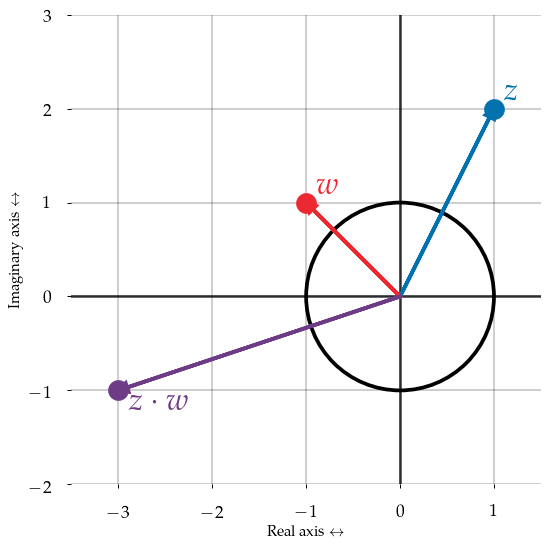

In [9]:
fig, ax = plt.subplots(figsize=figaspect(0.75))
z = 1 + 2j
w = -1 + 1j

zw = z * w

ax.scatter(z.real, z.imag, color=colors[0], label=r'$z$')
ax.text(z.real+.1, z.imag+.1, r'$z$', color=colors[0], size=25)
ax.arrow(0, 0, z.real, z.imag, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[0], ec=colors[0], length_includes_head=True)

ax.scatter(w.real, w.imag, color=colors[1], label=r'$w$')
ax.text(w.real+.1, w.imag+.1, r'$w$', color=colors[1], size=25)
ax.arrow(0, 0, w.real, w.imag, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[1], ec=colors[1], length_includes_head=True)

ax.scatter(zw.real, zw.imag, color=colors[4], label=r'$z\cdot w$')
ax.text(zw.real+.1, zw.imag-.2, r'$z\cdot w$', color=colors[4], size=25)
ax.arrow(0, 0, zw.real, zw.imag, linewidth=3, head_width=0.1,
           head_length=0.1, fc=colors[4], ec=colors[4], length_includes_head=True)

circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-1)
ax.add_artist(circ)
ax.axhline(0, color=colors[3], zorder=-1, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-1, linewidth=2)

ax.set_xlim(-3.5, 1.5)
ax.set_ylim(-2, 3)
ax.set_aspect('equal')
ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');

$$
\require{cancel}\notag%
$$
---
### Example 1: multiplying complex by reals

Let's keep $z = \color{#EC2830}{a} + \mathrm{j}\color{#6E3B87}{b}$ and multiply it by a purely real number $x$.
If we follow the rules above, we get

$$
\begin{align*}
z \cdot x &= (\color{#EC2830}{a} + \mathrm{j}\color{#6E3B87}{b}) \cdot x\\
&= \color{#EC2830}{a\cdot x} + \mathrm{j}\color{#6E3B87}{b\cdot x}
\end{align*}
$$

so the real $x$ combines with both the real and imaginary parts of $z$.

### Example 2: multiplying complex by imaginary

What if we multiply $z = \color{#EC2830}{a} + \mathrm{j}\color{#6E3B87}{b}$ a purely imaginary number $\mathrm{j}x$?
In this case, we get

$$
\begin{align*}
z \cdot\mathrm{j} x &= (\color{#EC2830}{a} + \mathrm{j}\color{#6E3B87}{b}) \cdot \mathrm{j}x\\
&= \color{#EC2830}{a}\cdot \mathrm{j}x + \mathrm{j}\color{#6E3B87}{b}\cdot \mathrm{j}x\\
&=  \color{#EC2830}{-b\cdot x} + \mathrm{j}\color{#6E3B87}{a\cdot x}.
\end{align*}
$$

In this case, the real and imaginary parts have exchanged places, and the new real part ($b \cdot x$) has been negated.

### Example 3: multiplying complex by its conjugate

Finally, what if we multiply a number $z = \color{#EC2830}{a} + \mathrm{j}\color{#6E3B87}{b}$ by its own conjugate $\overline{z} = \color{#EC2830}{a} - \mathrm{j}\color{#6E3B87}{b}$?

In this case, all of the imaginary components have cancelled each-other out, and the resulting product is purely real (and non-negative):

$$
\begin{align*}
z \cdot \overline{z} &= (\color{#EC2830}{a} + \mathrm{j}\color{#6E3B87}{b}) \cdot (\color{#EC2830}{a} - \mathrm{j}\color{#6E3B87}{b})\\
&= \color{#EC2830}{a}\cdot   \color{#EC2830}{a} + \mathrm{j}\color{#6E3B87}{b}\cdot   \color{#EC2830}{a}    - \color{#EC2830}{a} \cdot \mathrm{j}\color{#6E3B87}{b}   - \mathrm{j}\color{#6E3B87}{b}   \cdot \mathrm{j}\color{#6E3B87}{b}  & \text{FOIL multiply}\\
&= \color{#EC2830}{a}\cdot   \color{#EC2830}{a} + \cancel{\mathrm{j}\color{#6E3B87}{b}\cdot   \color{#EC2830}{a}}    - \cancel{\color{#EC2830}{a} \cdot \mathrm{j}\color{#6E3B87}{b}}   - \mathrm{j}\color{#6E3B87}{b}   \cdot \mathrm{j}\color{#6E3B87}{b}  & \text{Cancel } -\mathrm{j}ab + \mathrm{j}ab = 0\\
&= \color{#EC2830}{a}\cdot   \color{#EC2830}{a} - \mathrm{j}\color{#6E3B87}{b}   \cdot \mathrm{j}\color{#6E3B87}{b}  & \text{Substitute } \mathrm{j}^2 = -1 \\
&= \color{#EC2830}{a^2} + \color{#EC2830}{b^2}
\end{align*}
$$

---

We could say more about complex multiplication, but as we'll see, it's easier to think about if we use the *polar* form.
To see how that works, we'll need to take a slight detour through the exponential function.

## Complex exponentials

Recall from the [previous section](/appendix/Fundamentals.html) the definition of exponentials as a summation:

$$
e^x = \sum_{n=0}^{\infty} \frac{x^n}{n!}
$$

We previously saw this for real-valued $x$, but the idea carries over to *complex* exponentials $e^z$ for $z \in \mathbb{C}$ using exactly the same formula with $z$ in place of $x$.

Because any complex $z$ is the sum of its real and imaginary parts, it can be helpful to separate the exponential using the product rule:

$$
e^z = e^{a + \mathrm{j}b} = e^a \cdot e^{\mathrm{j}b}
$$

Since $a$ is real, we already have a good handle on how $e^a$ behaves.
Let's focus on what happens just to that second factor, where the quantity in the exponent is purely imaginary: $e^{\mathrm{j}b}$.

The animation below shows what happens as we form better approximations to $e^{\mathrm{j}b}$ by taking more terms in the summation (up to 50), for $b \in [-4\pi, +4\pi]$.
For clarity, the numbers in the interval $[-\pi, \pi]$ are highlighted.

In [10]:
%%capture
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.special import factorial

def make_partial_exp(b, N):
    # This function creates all partial sums up to N
    # approximating exp(b)
    n = np.arange(N)
    nf = factorial(n)
    powers = np.power(b, n[:, np.newaxis])
    return np.cumsum(powers / nf[:, np.newaxis], axis=0)

N_max = 50
frame_rate = 25
anim_duration = 10
n_frames = (anim_duration + 3) * frame_rate  

# -pi to pi range
t = np.linspace(- np.pi, np.pi, num=64)
v = make_partial_exp(1.j * t, N_max)

# pi to 4pi range
t2 = np.linspace(np.pi, 4 * np.pi, num=96)
v2 = make_partial_exp(1.j * t2, N_max)

# -4pi to pi range
t3 = np.linspace(-4 * np.pi, - np.pi, num=96)
v3 = make_partial_exp(1.j * t3, N_max)

# Now make the figure
fig, ax = plt.subplots(figsize=figaspect(0.75))
k = 4
p3 = ax.scatter(v3[k].real, v3[k].imag, s=5, color=colors[0], zorder=1, alpha=0.5)
p2 = ax.scatter(v2[k].real, v2[k].imag, s=5, color=colors[1], zorder=3, alpha=0.5)
p1 = ax.scatter(v[k].real, v[k].imag, c=t, cmap='coolwarm', zorder=2, s=50)

# Instead, make a text box and update its contents
eqbox = ax.text(-3.5, -3.75, r'$$e^{\mathrm{j}b} \approx \sum_{n=0}^{' + str(k) + r'}\frac{(\mathrm{j}b)^n}{n!}$$',
                   va='bottom')
ax.axhline(0, color=colors[3], zorder=-1, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-1, linewidth=2)
circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-1)
ax.add_artist(circ)

ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');
ax.set_aspect('equal', 'datalim')
cb = fig.colorbar(ScalarMappable(norm=Normalize(-np.pi, np.pi), 
                                  cmap='coolwarm'), label=r'$b$', ax=ax, 
                                  ticks=np.pi * np.linspace(-1, 1, num=5, endpoint=True),);

cb.ax.set_yticklabels([r'$-\pi$',r'-$\pi/2$', r'0', r'$\pi/2$', r'$\pi$'])

def init():
    return p1, p2, p3, eqbox

def animate(time):
    
    if time < anim_duration:
        
        # With no interpolation
        position = N_max * time / anim_duration
        k = int(position)
        alpha = position - k
        if k < N_max - 1:
            p1.set_offsets(np.c_[(1-alpha)*v[k].real + alpha * v[k+1].real,
                                     (1-alpha)*v[k].imag + alpha * v[k+1].imag])
            p2.set_offsets(np.c_[(1-alpha)*v2[k].real + alpha * v2[k+1].real,
                                     (1-alpha)*v2[k].imag + alpha * v2[k+1].imag])
            p3.set_offsets(np.c_[(1-alpha)*v3[k].real + alpha * v3[k+1].real,
                                     (1-alpha)*v3[k].imag + alpha * v3[k+1].imag])
            
        else:
            p1.set_offsets(np.c_[v[k].real, v[k].imag])
            p2.set_offsets(np.c_[v2[k].real, v2[k].imag])
            p3.set_offsets(np.c_[v3[k].real, v3[k].imag])
            
        eqbox.set_text(r'$$e^{\mathrm{j}b} \approx \sum_{n=0}^{' + str(k) + r'}\frac{(\mathrm{j}b)^n}{n!}$$')
        
    elif time == anim_duration:
        k = -1
        p1.set_offsets(np.c_[v[k].real, v[k].imag])
        p2.set_offsets(np.c_[v2[k].real, v2[k].imag])
        p3.set_offsets(np.c_[v3[k].real, v3[k].imag])
        
        eqbox.set_text(r'$$e^{\mathrm{j}b} \approx \sum_{n=0}^{' + str(N_max) + r'}\frac{(\mathrm{j}b)^n}{n!}$$')
    
    return p1, p2, p3, eqbox

animation = FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(n_frames, dtype=float) / frame_rate,
                               interval=1000/frame_rate, blit=True);

In [11]:
animation

### Euler's formula
The animation above shows that $e^{\mathrm{j}b}$ wraps imaginary numbers around the unit circle in the complex plane.
By visual inspection, one can see that the point $b=0$ maps to $z=1 + 0\mathrm{j}=1$, which makes sense since $e^0 = 1$.
More surprising are the points  $b=\pm\pi$, which both map to $z=-1$.
Even more surprising than that, larger values of $b > \pi$ or smaller values $b < -\pi$ also (eventually) wrap around the circle.

This phenomenon is summarized succinctly by **Euler's formula**:

$$
e^{\mathrm{j}\theta} = \color{#EC2830}{\cos(\theta)} + \mathrm{j}\cdot\color{#6E3B87}{\sin(\theta)}.
$$

In plain language, this formula says that if you take the exponential of a purely imaginary number, the result will be a complex number at unit distance from the origin, and with an angle matching the number.

**This is probably the most important formula in all of signal processing.**

### Polar and rectangular form

Euler's formula says what happens when you take the exponential of an imaginary number.
This might seem like an odd thing to do, but let's take a step back to think about what this tells about exponentials of *complex* numbers $z = a + \mathrm{j}b$.

Remember that $e^z = e^{a + \mathrm{j}b} = e^a \cdot e^{\mathrm{j}b}$.
Using Euler's formula, we can write this as

$$
\begin{align*}
e^z = e^a \cdot e^{\mathrm{j}b} &= e^a \cdot \left(\color{#EC2830}{\cos(b)} + \mathrm{j}\cdot\color{#6E3B87}{\sin(b)}\right)\\
&= e^a \cdot \color{#EC2830}{\cos(b)} + e^a \cdot\mathrm{j}\cdot\color{#6E3B87}{\sin(b)}.
\end{align*}
$$

**What does this buy us?**

Imagine picking any complex number $w = c + \mathrm{j}d$.
As we've seen earlier, this number can be represented by the point $(c, d)$ in the complex plane.
Equivalently, we can represent $w$ in **polar** form in terms of its distance from the origin (which we call $r$) and the angle $\theta$ it makes with the real axis.

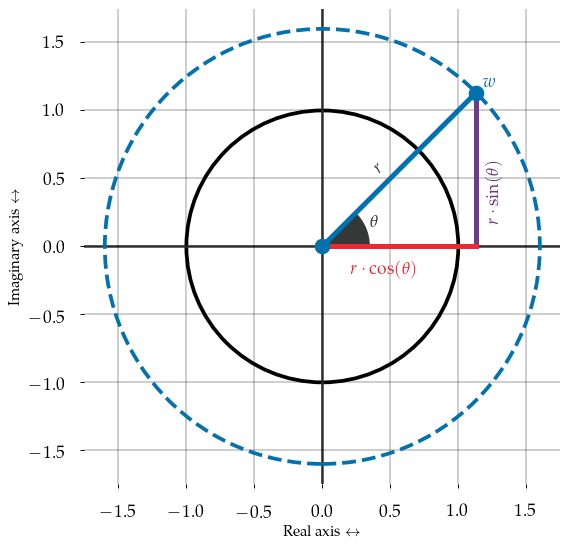

In [12]:
# Plot a circle, inscribed right triangle, angle, and sine and cosine markers
fig, ax = plt.subplots(figsize=figaspect(0.75))

r = 1.6
angle = np.pi / 4
x, y = r * np.cos(angle), r * np.sin(angle)

ucirc = patches.Ellipse((0, 0), 2, 2 , edgecolor='k', linewidth=3, fill=False, zorder=-1)
circ = patches.Ellipse((0, 0), 2 * r, 2 * r, edgecolor=colors[0], linewidth=3, linestyle='--', fill=False)

ax.text(1.2, 0.2, r'$r\cdot\sin(\theta)$', color=colors[4], rotation=90)
ax.plot([x, x], [0, y], linewidth=4, color=colors[4])

ax.text(0.2, -0.2, r'$r\cdot\cos(\theta)$', color=colors[1])
ax.plot([0, x], [0, 0], color=colors[1])

ax.text(0.35, 0.55, r'$r$', color=colors[3], rotation=angle * 180 / np.pi)
ax.plot([0, x], [0, y], marker='.', markersize=25, linewidth=4)

ax.text(x + 0.05, y + 0.05, r'$w$', color=colors[0])

arc = patches.Wedge((0, 0), 0.35, theta1=0, theta2=angle * 180 / np.pi, facecolor=colors[3])
ax.text(0.35, 0.15, r'$\theta$', color=colors[3])

ax.add_patch(ucirc)
ax.add_patch(circ)
ax.add_patch(arc)

ax.axhline(0, color=colors[3], zorder=-1, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-1, linewidth=2)

ax.set_xlim([-1.75, 1.75])
ax.set_ylim([-1.75, 1.75]);
ax.set_aspect('equal')
ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');

Putting this picture back into equations, *any complex number* $z$ can be equivalently expressed using Euler's formula as

$$
\begin{align*}
z &= r \cdot \left(\color{#EC2830}{\cos(\theta)} + \mathrm{j}\cdot\color{#6E3B87}{\sin(\theta)} \right)\\
  &= r \cdot e^{\mathrm{j}\theta}
\end{align*}
$$

for some radius $r\geq 0$ and angle $\theta$.  This is what we mean by the **polar form** of a complex number.
The radius $r$ of the circle is also called the **magnitude** of the complex number; the angle $\theta$ is called either the **angle** or the **phase** of the number.

If we're given a complex number in polar form (that is, we're given $(r,\theta)$), Euler's formula tells us how to convert it to rectangular form:

$$
\begin{align*}
\color{#EC2830}{a} &= \color{#EC2830}{r\cdot \cos(\theta)}\\
\color{#6E3B87}{b} &= \color{#6E3B87}{r\cdot \sin(\theta)}.
\end{align*}
$$

If instead, we're given a complex number in rectangular form (in terms of $(a, b)$), we can convert to polar form by using the Pythagorean theorem to find
the radius, and some geometry to find the angle:

$$
\begin{align*}
r^2 &= \color{#EC2830}{a^2} + \color{#6E3B87}{b^2} \quad &\Rightarrow r &= \sqrt{\color{#EC2830}{a^2} + \color{#6E3B87}{b^2}}\\
\tan(\theta) &
= \frac{\color{#6E3B87}{\sin(\theta)}}{\color{#EC2830}{\cos(\theta)}}
= \frac{\color{#6E3B87}{r\cdot \sin(\theta)}}{\color{#EC2830}{r \cdot \cos(\theta)}} 
= \frac{\color{#6E3B87}{b}}{\color{#EC2830}{a}}
\quad &\Rightarrow \theta &= \tan^{-1}\left(\frac{\color{#6E3B87}{b}}{\color{#EC2830}{a}}\right).
\end{align*}
$$

where $\tan^{-1}$ is the inverse or *arc-tangent* function.

````{margin}
In practice, you shouldn't compute the angle using the arc tangent directly.
This is because dividing $b/a$ can be numerically unstable when $a$ is a small number.

```{code-block}
# Don't do this!
np.arctan(1.0/0.0)
```


Instead, most mathematical software libraries give you functions to compute the inverse tanget without having to do the division first.


```{code-block}
# Do this instead
np.arctan2(1.0, 0.0)
```


You can do even better by using the `numpy` functions to extract magnitude and angle from a complex number:


```{code-block}
np.abs(0+1j)
np.angle(0+1j)
```
````

The key point here is that it's always possible to represent a complex number in either polar or rectangular form.
Rectangular form is convenient when adding or subtracting complex numbers.
As we'll see below, polar form is more convenient for multiplying and dividing.

## Multiplication (take 2)

We previously saw how to multiply two complex numbers in rectangular form, but let's see what happens when we use polar form instead.

Say we're given two numbers $z = r\cdot e^{\mathrm{j}\theta}$ and $w = s\cdot e^{\mathrm{j}\phi}$.
We can use the rules of exponents (covered [previously](/appendix/Fundamentals.html#Rules-for-working-with-exponentials)) to simplify this:

$$
\begin{align*}
z\cdot w &= r\cdot e^{\mathrm{j}\theta} \cdot s\cdot e^{\mathrm{j}\phi}\\
&= (r \cdot s) \cdot e^{\mathrm{j}\theta} \cdot e^{\mathrm{j}\phi} & \text{Collect exponentials together}\\
&= (r \cdot s) \cdot e^{\mathrm{j}\theta + \mathrm{j}\phi} & \text{Use rule: } e^x  \cdot e^y = e^{x+y}\\
&= (r \cdot s) \cdot e^{\mathrm{j}(\theta + \phi)} & \text{Pull out common factor of }\mathrm{j}.
\end{align*}
$$

The result in a new complex number in polar form, with magnitude $r\cdot s$ and angle $\theta + \phi$.
There's a helpful mnemonic device for remembering this:

**Magnitudes multiply** and **angles add**.

In the special case where $s=1$, the magnitude is preserved, and all that happens is that the angle moves from $\theta \rightarrow \theta + \phi$.
But adding angles is nothing more than **rotation**!


In [13]:
%%capture
#  angle moving continuously from pi/4 around the circle
#  magnitude oscillating 1 + 0.5 * cos
#fig = plt.figure()
#ax = fig.gca()
fig, ax = plt.subplots(figsize=figaspect(0.75))

duration = 15
frame_rate = 25
n_frames = duration * frame_rate

z = 1.25 * np.exp(1j * np.pi * 2./3)

w = np.exp(1.j * np.linspace(np.pi/6, 2*np.pi + np.pi/6, num=n_frames, endpoint=False))
w *= 0.5 * (2 - np.cos(2 * np.pi * np.linspace(0, 1, num=n_frames, endpoint=False)))
zw = z * w

angle_z = np.angle(z)
angle_w = np.angle(w)

angle_zw = np.angle(zw)

zp = ax.scatter(z.real, z.imag, color=colors[0], label=r'$z$')
zt = ax.text(z.real + .1, z.imag + .1, r'$z$', color=colors[0])
zl = ax.plot([0, z.real], [0, z.imag], color=colors[0], linewidth=2, zorder=-1)[0]

zarc = patches.Wedge((0, 0), 0.35, theta1=0, theta2=angle_z * 180 / np.pi, facecolor=colors[0], zorder=1, alpha=0.75)
ax.add_patch(zarc)

zarc2 = patches.Wedge((-2, -2), 0.2, theta1=0, theta2=angle_z * 180 / np.pi, facecolor=colors[0], zorder=2, alpha=0.75)
ax.add_patch(zarc2)


wp = ax.scatter(w[0].real, w[0].imag, color=colors[1], label=r'$w$')
wt = ax.text(w[0].real + .1, w[0].imag + .1, r'$w$', color=colors[1])
wl = ax.plot([0, w[0].real], [0, w[0].imag], color=colors[1], linewidth=2, zorder=1)[0]

warc = patches.Wedge((0, 0), 0.27, theta1=0, theta2=angle_w[0] * 180 / np.pi, facecolor=colors[1], zorder=2, alpha=0.75)
ax.add_patch(warc)

warc2 = patches.Wedge((-2, -2), 0.2, theta1=0, theta2=(angle_z + angle_w[0]) * 180 / np.pi, facecolor=colors[1], zorder=1, alpha=0.75)
ax.add_patch(warc2)

zwp = ax.scatter(zw[0].real, zw[0].imag, color=colors[4], label=r'$z\cdot w$')
zwt = ax.text(zw[0].real + .1, zw[0].imag + .1, r'$z\cdot w$', color=colors[4])
zwl = ax.plot([0, zw[0].real], [0, zw[0].imag], color=colors[4], linewidth=2, zorder=32)[0]

zwarc = patches.Wedge((0, 0), 0.2, theta1=0, theta2=angle_zw[0] * 180 / np.pi, facecolor=colors[4], zorder=3, alpha=0.75)
ax.add_patch(zwarc)

zwarc2 = patches.Wedge((-1, -2), 0.2, theta1=0, theta2=angle_zw[0] * 180 / np.pi, facecolor=colors[4], zorder=3, alpha=0.75)
ax.add_patch(zwarc2)

ax.text(-1.5, -2, r'$=$', size=30, ha='center', va='center')

circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-10)
ax.add_artist(circ)
ax.axhline(0, color=colors[3], zorder=-10, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-10, linewidth=2)

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');

def init():
    return wp, zwp, wt, zwt, wl, zwl, zarc2, warc, zwarc, warc2, zwarc2

def animate(frame):
    
    wp.set_offsets(np.c_[w[frame].real, w[frame].imag])
    zwp.set_offsets(np.c_[zw[frame].real, zw[frame].imag])

    wl.set_data([0, w[frame].real], [0, w[frame].imag])
    zwl.set_data([0, zw[frame].real], [0, zw[frame].imag])
    
    wt.set_x(w[frame].real + 0.1)
    wt.set_y(w[frame].imag + 0.1)
    
    zwt.set_x(zw[frame].real + 0.1)
    zwt.set_y(zw[frame].imag + 0.1)
    
    warc.set_theta2(angle_w[frame] * 180 / np.pi)
    zwarc.set_theta2(angle_zw[frame] * 180 / np.pi)
    zarc2.set_theta1(angle_w[frame] * 180 / np.pi)
    zarc2.set_theta2((angle_z + angle_w[frame]) * 180 / np.pi)
    warc2.set_theta2(angle_w[frame] * 180 / np.pi)
    zwarc2.set_theta2(angle_zw[frame] * 180 / np.pi)
    return wp, zwp, wt, zwt, wl, zwl, zarc2, warc, zwarc, warc2, zwarc2

animation = FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(n_frames),
                               interval=1000/frame_rate, blit=True);

In [14]:
animation

## Inversion (division)

We skipped over inversion and division when working in rectangular coordinates.
It's certainly not impossible to do these operations with rectangular coordinates, but it's much simpler in polar form if we use the rule

$$
\frac{1}{e^x} = e^{-x}.
$$

A complex number $z$ can therefore be inverted to get $z^{-1}$:

$$
\frac{1}{z} = \frac{1}{r \cdot e^{\mathrm{j}\theta}} = \frac{1}{r} \cdot e^{-\mathrm{j}\theta}.
$$

That is, the radius is *inverted*, and the angle is *negated*.

The animation below shows how a complex number and its inverse relate to each other.
Some things to pay attention to here:

- $z$ and $z^{-1}$ cross the unit circle at the same time, since $r=1$ is its own inverse.
- When $z$ is outside the unit circle, the inverse is inside, and vice versa.
- $z$ and $z^{-1}$ cross the both horizontal and vertical axes at the same time, but in general, both their horizontal and vertical positions can be different.
- There are two points at which $z$ and $z^{-1}$ coincide exactly: $z = 1$ and $z=-1$.

In [15]:
%%capture
#  angle moving continuously from pi/4 around the circle
#  magnitude oscillating 1 + 0.5 * cos
fig, ax = plt.subplots(figsize=figaspect(0.75))

duration = 15
frame_rate = 25
n_frames = duration * frame_rate

z = np.exp(1.j * np.linspace(np.pi/4, 9 * np.pi/4, num=n_frames, endpoint=False))
z *= 1 + 0.25 * np.sin(2 * np.pi * 4 * np.linspace(0, 1, num=n_frames, endpoint=False))
zinv = z**-1

zp = ax.scatter(z[0].real, z[0].imag, color=colors[0], label=r'$z$')
zt = ax.text(z[0].real + .1, z[0].imag + .1, r'$z$', color=colors[0], size=25)


zinvp = ax.scatter(zinv[0].real, zinv[0].imag, color=colors[1], label=r'$z^{-1}$')
zinvt = ax.text(zinv[0].real + .1, zinv[0].imag + .1, r'$z^{-1}$', color=colors[1], size=25)

circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-1)
ax.add_artist(circ)
ax.axhline(0, color=colors[3], zorder=-1, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-1, linewidth=2)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');

def init():
    return zp, zinvp, zt, zinvt

def animate(frame):
    
    zp.set_offsets(np.c_[z[frame].real, z[frame].imag])
    zinvp.set_offsets(np.c_[zinv[frame].real, zinv[frame].imag])

    zt.set_x(z[frame].real + 0.1)
    zt.set_y(z[frame].imag + 0.1)
    zinvt.set_x(zinv[frame].real + 0.1)
    zinvt.set_y(zinv[frame].imag + 0.1)
    return zp, zinvp, zt, zinvt


animation = FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(n_frames),
                               interval=1000/frame_rate, blit=True);

In [16]:
animation

If you want to divide two complex numbers $z = r\cdot e^{\mathrm{j}\theta}$ and $w = s\cdot e^{\mathrm{j}\phi}$  as $z/w$, it's equivalent to multiply by the inverse $z\cdot w^{-1}$.
This results in

$$
\frac{z}{w} = \frac{r \cdot e^{\mathrm{j}\theta}}{s\cdot e^{\mathrm{j}\phi}} = \frac{r}{s} \cdot e^{\mathrm{j}(\theta - \phi)}
$$

## Powers of complex numbers

Now that we've seen how complex numbers behave when multiplied together, we might also wonder what happens when a complex number is multiplied by itself repeatedly.
Of specific importance in signal processing is the sequence

$$
z^0, z^1, z^2, \cdots, z^n, \cdots
$$

If we pick an arbitrary point in this sequence, $z^n$ for some $n\geq 0$, we can express the corresponding term in polar form as follows

$$
z^n = {\left(r\cdot e^{\mathsf{j}\theta}\right)}^n = r^n \cdot e^{\mathsf{j} \cdot n \theta},
$$

where $z = r\cdot e^{\mathsf{j}\theta}$ and the second equality follows from the product rule for exponents.

From this, we can see that the $n$th step in the sequence will place the point at angle $n\cdot \theta$, and radius $r^n$.

If $r < 1$, this sequence will have decreasing radius, and it will spiral into the origin.
If $r > 1$, the sequence will have increasing radius, and it will spiral out.
If $r=1$, each element will have the same radius since $1^n = 1$: the sequence will therefore loop around the circle indefinitely.

If $0 \leq \theta \leq \pi$, the spiral will wind counter-clockwise, and otherwise it will wind counter-clockwise, as demonstrated below.
Larger angles (closer to $\pm\pi$) rotate faster than smaller angles (closer to $0$).

In [17]:
%%capture
# Animated plot of spiraling complex exponentials

Nmax = 20
frame_rate = 25

n_frames = Nmax * frame_rate
duration = n_frames // frame_rate

fig, ax = plt.subplots(figsize=figaspect(0.75))
circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-4)
ax.add_artist(circ)
ax.axhline(0, color=colors[3], zorder=-4, linewidth=2)
ax.axvline(0, color=colors[3], zorder=-4, linewidth=2)

ax.set_xlabel(r'Real axis $\leftrightarrow$')
ax.set_ylabel(r'Imaginary axis  $\leftrightarrow$');

z1 = 0.9 * np.exp(1.j * 3 * np.pi/4)
z2 = 1.1 * np.exp(-1.j * np.pi/6)
z3 = np.exp(1.j * np.pi/3)


n = np.arange(Nmax)

d1 = z1**n
d2 = z2**n
d3 = z3**n

curve = np.linspace(0, n.max(), num=int(duration*frame_rate))
c1 = z1**curve
c2 = z2**curve
c3 = z3**curve

p1 = ax.plot([z1.real], [z1.imag], label=r'$r=0.9$, $\theta=3\pi/4$',
           marker='o', markersize=15, linewidth=0, color=colors[0])[0]
pd1 = ax.plot(d1.real, d1.imag, marker='o', markersize=7, linewidth=0, color=colors[0], visible=False)[0]
pc1 = ax.plot(c1.real, c1.imag, linewidth=2, zorder=-1, color=colors[0], linestyle='--', visible=False)[0]

p2 = ax.plot([z2.real], [z2.imag], label=r'$r=1.1$, $\theta=-\pi/6$',
           marker='o', markersize=15, linewidth=0, color=colors[1])[0]
pd2 = ax.plot(d2.real, d2.imag, marker='o', markersize=7, linewidth=0, color=colors[1], visible=False)[0]
pc2 = ax.plot(c2.real, c2.imag, linewidth=2, zorder=-1, color=colors[1], linestyle='--', visible=False)[0]

p3 = ax.plot([z3.real], [z3.imag], label=r'$r=1$, $\theta=\pi/3$',
           marker='o', markersize=15, linewidth=0, color=colors[2])[0]
pd3 = ax.plot(d3.real, d3.imag, marker='o', markersize=7, linewidth=0, color=colors[2], visible=False)[0]
pc3 = ax.plot(c3.real, c3.imag, linewidth=2, zorder=-1, color=colors[2], linestyle='--', visible=False)[0]

pn = ax.text(-1.75, -1.75, r"$z^{" + '{:d}'.format(1) + r"}$", color=colors[4], size=25, visible=False)
plt.legend(loc='upper right')
ax.set_aspect('equal')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2]);

def init():
    pc1.set_visible(True)
    pc2.set_visible(True)
    pc3.set_visible(True)
    pd1.set_visible(True)
    pd2.set_visible(True)
    pd3.set_visible(True)
    pn.set_visible(True)
    return pc1, pc2, pc3, pd1, pd2, pd3, pn

def animate(frame):
    n = frame // frame_rate
    pc1.set_data(c1.real[:frame+1], c1.imag[:frame+1])
    pc2.set_data(c2.real[:frame+1], c2.imag[:frame+1])
    pc3.set_data(c3.real[:frame+1], c3.imag[:frame+1])
    pd1.set_data(d1.real[:n+1], d1.imag[:n+1])
    pd2.set_data(d2.real[:n+1], d2.imag[:n+1])
    pd3.set_data(d3.real[:n+1], d3.imag[:n+1])
    pn.set_text(r"$z^{" + '{:d}'.format(int(curve[frame])) + r"}$")
    return pc1, pc2, pc3, pd1, pd2, pd3, pn

animation = FuncAnimation(fig, animate, init_func=init,
                         frames=np.arange(n_frames),
                         interval=1000/frame_rate, blit=True)

In [18]:
animation

If we take just the real (or imaginary) part of $z^n$ for the sequence of values of $n$, we'll see a sinusoid with decaying ($r < 1$), increasing ($r>1$), or stable ($r=1$) amplitude, as illustrated below for the real part (top) and imaginary part (bottom).

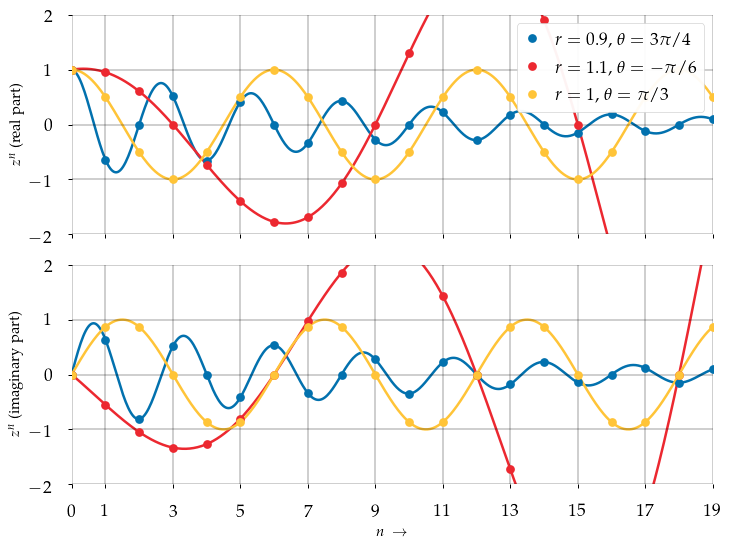

In [19]:
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figaspect(0.75))

ax.plot(n, d1.real, marker='o', label=r'$r=0.9$, $\theta=3\pi/4$', markersize=7, linewidth=0, color=colors[0])
ax.plot(curve, c1.real, linewidth=2, zorder=-1, color=colors[0])

ax.plot(n, d2.real, marker='o', label=r'$r=1.1$, $\theta=-\pi/6$',markersize=7, linewidth=0, color=colors[1])
ax.plot(curve, c2.real, linewidth=2, zorder=-1, color=colors[1])

ax.plot(n, d3.real, label=r'$r=1$, $\theta=\pi/3$', marker='o', markersize=7, linewidth=0, color=colors[2])
ax.plot(curve, c3.real, linewidth=2, zorder=-1, color=colors[2])
ax.set_xlim([0, 19])
ax.set_ylim([-2, 2])
ax.set_xlabel(r'$n~\rightarrow$')
ax.set_ylabel(r'$z^n$ (real part)');
ax.legend(loc='upper right');
ax.label_outer()

ax2.plot(n, d1.imag,marker='o', markersize=7, linewidth=0, color=colors[0])
ax2.plot(curve, c1.imag, linewidth=2, zorder=-1, color=colors[0])

ax2.plot(n, d2.imag, marker='o', markersize=7, linewidth=0, color=colors[1])
ax2.plot(curve, c2.imag, linewidth=2, zorder=-1, color=colors[1])

ax2.plot(n, d3.imag, marker='o', markersize=7, linewidth=0, color=colors[2])
ax2.plot(curve, c3.imag, linewidth=2, zorder=-1, color=colors[2])
ax2.set_ylim([-2, 2])
ax2.set_xticks([0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19])
ax2.set_xlabel(r'$n~\rightarrow$')
ax2.set_ylabel(r'$z^n$ (imaginary part)');
ax2.label_outer();

From these plots, we can see that any complex number $z$ can be used to generate what is known as a **complex sinusoid** by raising it to successive powers $z^n$.
This idea forms the basis of the (discrete) Fourier transform (covered in chapter 5) and the z-Transform (chapter 11).